# fruits-360 Decision Tree Classifier

This notebook uses the data found at https://github.com/Horea94/Fruit-Images-Dataset and the `training_path` and `testing_path` must be replaced with your own paths to the data if re-running it.

### Notebook-wide variables and functions

The functions below load the data into np arrays

In [1]:
import os
import cv2
import numpy as np

training_path = r'C:/Users/Parker/Desktop/fruits-360/Training/'
testing_path = r'C:/Users/Parker/Desktop/fruits-360/Validation/'
label_to_int = {}
int_to_label = {}
training_images = None
testing_images = None
training_labels = []
testing_labels = []

def get_image_list(image_path):
    image_path.replace('\\', '/')
    image = np.array(cv2.resize(cv2.imread(image_path, cv2.IMREAD_UNCHANGED), (50, 50)))
    image = np.reshape(image, len(image) * len(image) * 3)
    image = image.tolist()
    return image

def make_fruits_360_array(fruits_dir):
    temp_images = []
    temp_labels = []
    for subdir, dirs, files in os.walk(fruits_dir):
        if not label_to_int or not int_to_label:
            for i, dir in enumerate(dirs):  # Setup label dictionaries
                label_to_int[dir] = i
                int_to_label[i] = dir
        for file in files:
            label = os.path.basename(os.path.normpath(subdir))
            temp_images += [get_image_list(os.path.join(subdir, file))]
            temp_labels += [label_to_int[label]]
    return np.array(temp_images), np.array(temp_labels)

### Training arrays

Here we make the arrays containing the pixel information and label

In [2]:
training_images, training_labels = make_fruits_360_array(training_path)

There should be 28736 training images:

In [3]:
len(training_images)

28736

Each image array is actually 7500 long (3 rgb * 50 width * 50 height)

In [4]:
training_images

array([[255, 255, 254, ..., 255, 255, 255],
       [252, 255, 254, ..., 255, 255, 255],
       [251, 255, 253, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

Let's take a look at the 4000th and 5000th fruit:

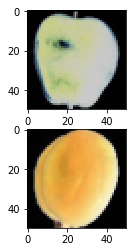

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot(211)
plt.imshow(np.vectorize(float)((training_images[4000].reshape(50, 50, 3))))
plt.subplot(212)
plt.imshow(np.vectorize(float)((training_images[5000].reshape(50, 50, 3))))

Here is another way of visualizing the differences between the two:

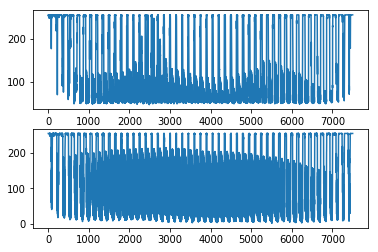

In [6]:
plt.subplot(211)
plt.plot(training_images[4000])
plt.subplot(212)
plt.plot(training_images[5000])

Turns out the 4000th one is an "Apple Red Delicious" and the 5000th one is an "Apricot."

In [7]:
int_to_label[training_labels[4000]], int_to_label[training_labels[5000]]

('Apple Red Delicious', 'Apricot')

### Testing arrays

Here we make the testing image arrays and labels with the same function as the training ones

In [8]:
testing_images, testing_labels = make_fruits_360_array(testing_path)

In [9]:
len(testing_images)

9673

It's good practice to shuffle the training data with a set seed, so here we make the same shuffle of the training images and labels.

In [10]:
np.random.seed(50)
perm = np.random.permutation(len(training_images))
shuffled_training_images = training_images[perm]
shuffled_training_labels = training_labels[perm]

Just to see that it worked, here are the 4000th and 5000th fruits now. Different!

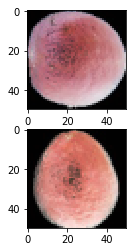

In [11]:
plt.subplot(211)
plt.imshow(np.vectorize(float)((shuffled_training_images[4000].reshape(50, 50, 3))))
plt.subplot(212)
plt.imshow(np.vectorize(float)((shuffled_training_images[5000].reshape(50, 50, 3))))

### Decision Tree Classifier

In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(shuffled_training_images, shuffled_training_labels)

The classifier has now been trained on the shuffled training data. As we can see below, it gets at least the first 3 and last 3 right from the testing set (since they are in order).

In [13]:
clf.predict(testing_images)

array([ 0,  0,  0, ..., 59, 59, 59])

When we see how it does overall, we see that it gets 76.97% of 9673 test images correct. For 60 different categories, that is pretty great!

In [14]:
clf.score(testing_images, testing_labels)

0.7697715289982425

In [17]:
clf.score(training_images, training_labels)

1.0

### Visualize

Using graphviz, we can see the actual decision tree. It turns out that for this data, this tree turns out HUGE!

In [15]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [16]:
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.270475 to fit



In [103]:
((len(training_images[0]), len(int_to_label)), (int(clf.n_features_), clf.n_classes_))

((7500, 60), (7500, 60))

In [101]:
(clf.tree_.node_count, clf.tree_.max_depth)

(1723L, 35L)

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(training_images)
pca_2d = pca.transform(training_images)

In [59]:
pca_2d

array([[ 3849.33273483, -1884.54334197],
       [ 5282.47323336, -1218.9740606 ],
       [ 5277.53806707, -1196.43179664],
       ...,
       [  847.84123909, -1543.25529575],
       [  870.24168114, -1556.4658896 ],
       [  193.33657301, -1645.73179573]])

In [46]:
xs = np.array([i[0] for i in pca_2d])
ys = np.array([i[1] for i in pca_2d])

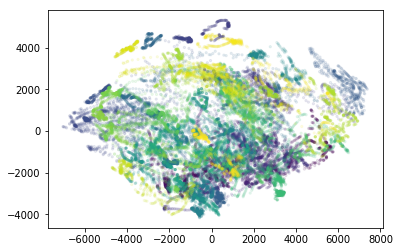

In [76]:
plt.scatter(xs, ys, c=training_labels, alpha=0.1, s=5)

In [69]:
pca1 = PCA(n_components=1).fit(training_images)
pca_1d = pca1.transform(training_images)

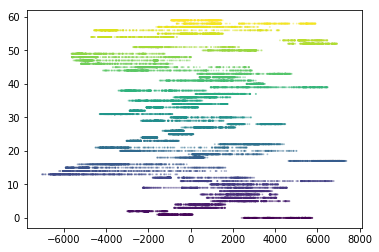

In [74]:
plt.scatter(pca_1d, training_labels, c=training_labels, alpha=0.3, s=1)

In [234]:
max_dims = len([i for i in clf.feature_importances_ if i != 0.0])
max_dims

801

In [209]:
dims = len([i for i in clf.feature_importances_ if i > 0.0001])
dims

561

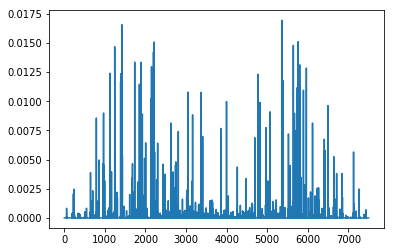

In [226]:
plt.plot(clf.feature_importances_)

In [213]:
training_images_dim_reduced = PCA(n_components=dims).fit(training_images).transform(training_images)

In [215]:
len(training_images_dim_reduced[0])

561

In [229]:
shuffled_train_dim_reduced = training_images_dim_reduced[perm]

In [230]:
clf_rdim = tree.DecisionTreeClassifier().fit(shuffled_train_dim_reduced, shuffled_training_labels)

In [231]:
testing_images_dim_reduced = PCA(n_components=dims).fit(testing_images).transform(testing_images)

In [232]:
clf_rdim.score(testing_images_dim_reduced, testing_labels)

0.2717874496019849

In [233]:
clf_rdim.score(training_images_dim_reduced, training_labels)

1.0

In [235]:
max_train_dim_reduced = PCA(n_components=max_dims).fit(training_images).transform(training_images)

In [236]:
shuffled_max_train_dim_reduced = max_train_dim_reduced[perm]

In [237]:
clf_max_rdim = tree.DecisionTreeClassifier().fit(shuffled_max_train_dim_reduced, shuffled_training_labels)

In [238]:
testing_images_dim_reduced = PCA(n_components=max_dims).fit(testing_images).transform(testing_images)

In [239]:
clf_max_rdim.score(testing_images_dim_reduced, testing_labels)

0.24925049105758296

In [241]:
clf_max_rdim.score(max_train_dim_reduced, training_labels)

1.0